1. UZASADNIENIE BIZNESOWE

Celem nadrzędnym jest znajdowanie obszarów/terenów gdzie mamy do czynienia z niewystarczającą siecią przesyłową energii elektrycznej względem produkowanej energii przez panele fotowoltaiczne. Identyfikacja pozwoli określić priorytetowe miejsca do modernizacji sieci.
Model przeprowadza identyfikację i pomiar powierzchni paneli fotowoltaicznych na wybranym obszarze na podstawie zdjęć saltelitarnych oraz zdjęć i nagrań z drona lub samolotu. 
Pomiary będą wykorzystywane do oszacowania mocy (kW) produkowanej przez gospodarstwa domowe a także farmy na danym obszarze. Wyliczona moc będzie zestawiana z możliwościami sieci przesyłowej energii na badanym obszarze. 


2. NARZĘDZIA

Do identyfikacji i pomiaró paneli pv posłuży model YOLO w wersji 8 typu 'seg' ('yolov8n-seg.pt'). Ta wersja i typ spełniają wymagania określenia powierzchni paneli także w nieregularnym kształcie z względnie duzą dokładnością.

YOLO w wersji do segmentowania obiektów jest odpowiednim modelem ponieważ, potrafi przeprowadzić detekcję obiektów w czasie rzeczywistym (np. nagranie) i potrafi nałożyć dokładną maskę na znaleziony obiekt. Nałożona maska bitowa da informację o ilości pixeli a ilość pixeli względem odpowiedniej skali pozwoli określić powierzchnię paneli pv.

3. TWORZENIE MODELU

In [10]:
from ultralytics import YOLO
import os

In [11]:
#Inicjalizacja danych
data_path = "C:/Users/dkw/VisualStudioProjects/ControllingDKW/DS/ProjektKońcowy2"
dataset_yaml_path = os.path.join(data_path, 'data.yaml')

In [12]:
#Inicjalizacja modelu YOLOv9 dla segmentacji (transfer learning)
model = YOLO('yolov8n-seg.pt') 

4. DOTRENOWANIE MODELU BAZOWEGO YOLO (yolov8n-seg.pt)

Do dotrenowania modelu posłuży dataset pobrany z platformy universe.robolow (https://universe.roboflow.com/soloyolo/solarsegmentation-zs1vs/dataset/15).
 
Zbiór składa się 2215 zdjęć o rozmiarze 640x640 każde, które są podzielone na 3 części wg następujących proporcji:
- 88% zbiór treningowy
- 8% zbiór walidacyjny
- 4% zbiór testowy

Problemy z danymi

Pobrany dataset wymagał zawierał  wszystkie annotacje w jednym pliku w wersji COCO w formacie json. Zaś dla YOLO odpowiednie są osobne annotacje dla każdego zdjęcia w plikach tekstowych zawierajaćego współrzędne poligonów tworzących maski obiektów. W związku z tym wymagana była konwersja z coco.json na polygons.txt

Kolejnym problem było to, że annotacje w datasecie były dla trzech klas obiektów:
 - klasa 0 'pv' określająca maski dla paneli fotowoltaicznych
 - klasy 1 'ued' i 2 'st' nie opisane przez twórcę datasetu
W związku z tym model będzie trenowany dla 3 klas obiektów, ale metryki będą oceniane tylko dla klasy obiektów 'pv'.

In [ ]:
# Trening modelu dla obrazów w dataset 640x640
model.train(data=dataset_yaml_path, epochs=20, imgsz=640, batch=16, project='runs/train', name='exp')


5. WYNIKI DLA KLASY OBIEKTÓW 

-WSZYSTKIE KLASY OBIEKTÓW

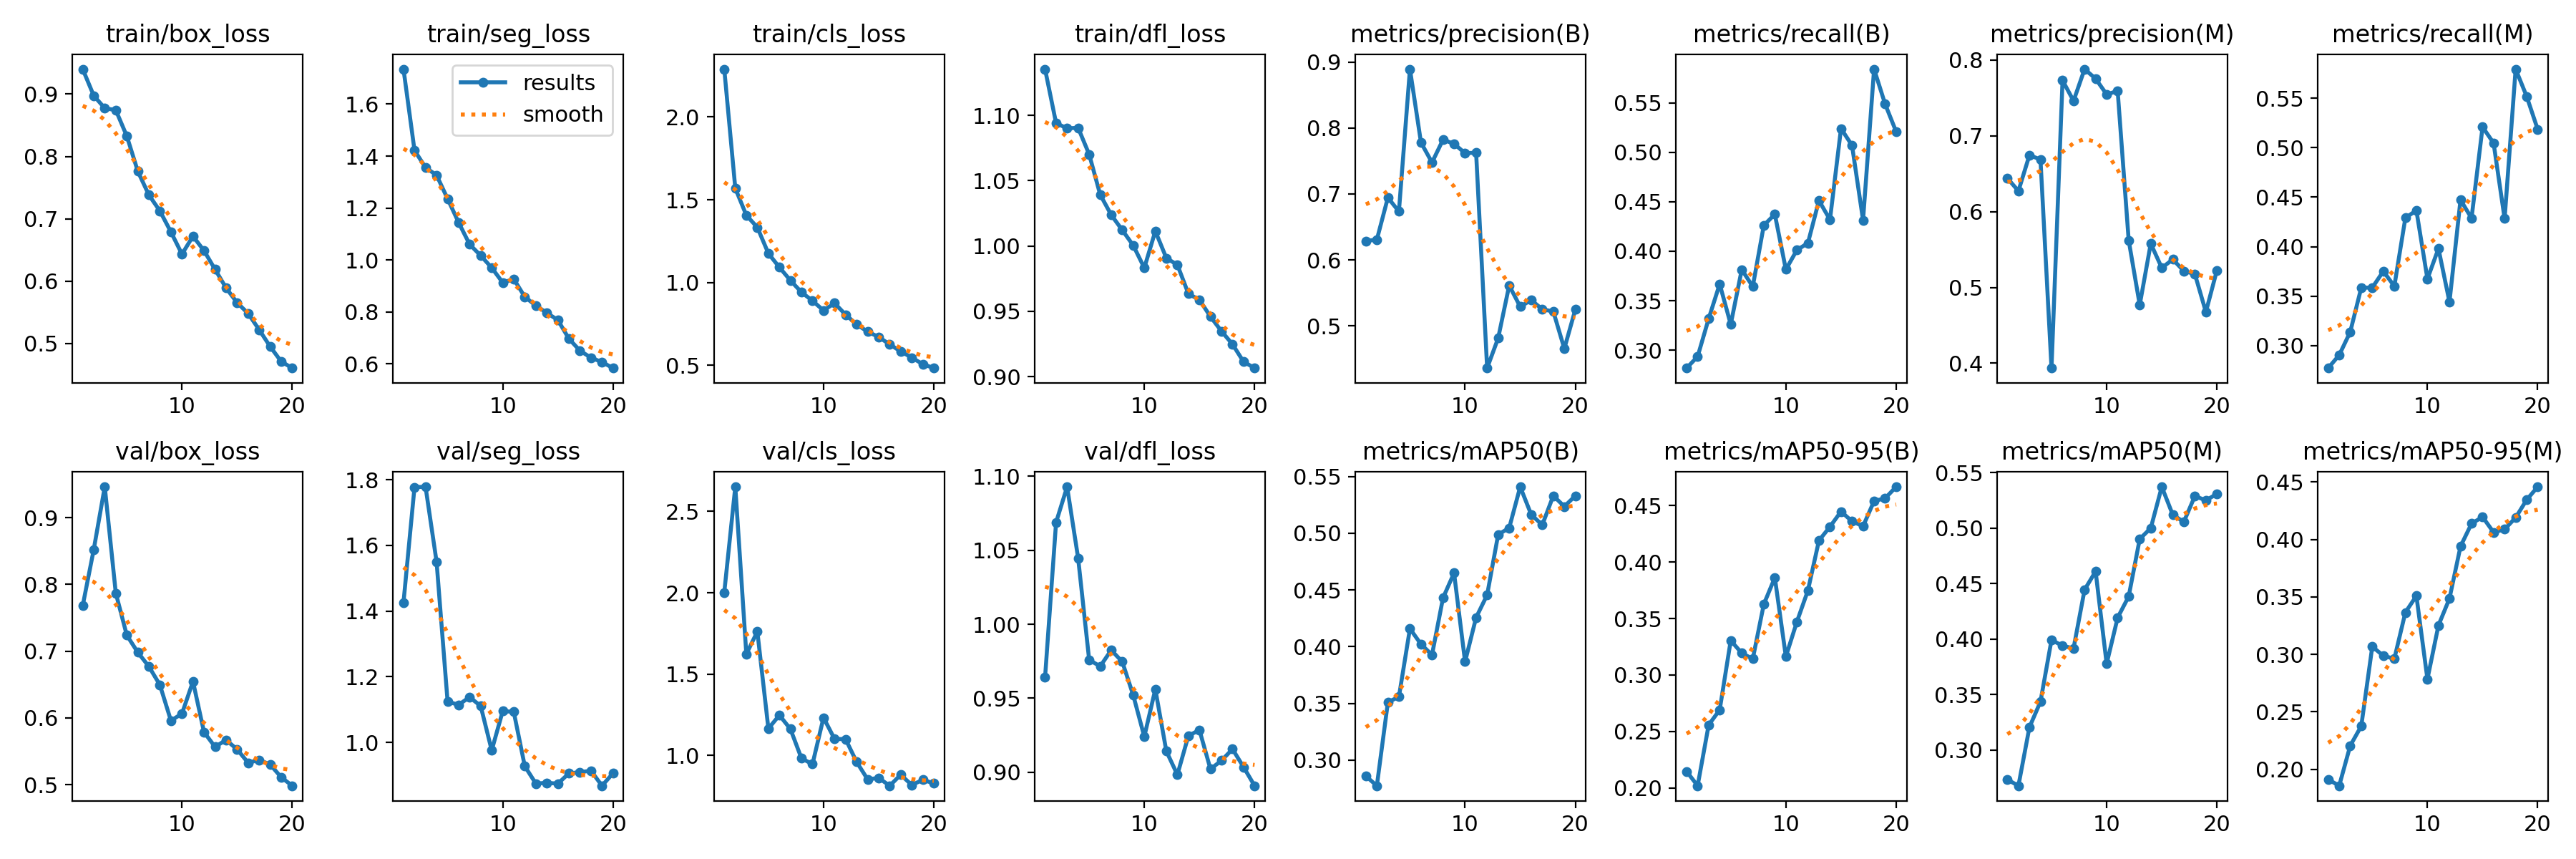

In [1]:
from IPython.display import Image, display

image_path = r'C:\Users\dkw\VisualStudioProjects\ControllingDKW\DS\ProjektKońcowy2\runs\train\exp\results.png'
display(Image(filename=image_path))


- W PODZIALE NA KLASY OBIEKTÓW

In [14]:
metrics = model.val()

Ultralytics YOLOv8.2.55  Python-3.11.3 torch-2.3.1+cpu CPU (AMD Ryzen 5 PRO 6650U with Radeon Graphics)
YOLOv8n-seg summary (fused): 195 layers, 3,258,649 parameters, 0 gradients, 12.0 GFLOPs


val: Scanning C:\Users\dkw\VisualStudioProjects\ControllingDKW\DS\ProjektKońcowy2\valid\labels.cache... 181 images, 11 backgrounds, 0 corrupt: 100%|██████████| 181/181 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:55<00:00,  4.60s/it]


                   all        181        492      0.524      0.521      0.533      0.466      0.521      0.519      0.531      0.446
                    pv        156        423      0.818      0.839      0.891      0.798      0.811      0.832      0.878      0.753
                    st          6          7      0.186      0.143      0.101     0.0623      0.186      0.143      0.101     0.0617
                   ued         44         62      0.568      0.581      0.606      0.539      0.568      0.581      0.613      0.523
Speed: 3.3ms preprocess, 283.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs\train\exp2


6. PREDYKCJA NA BAZIE TESTOWEJ

In [ ]:
from ultralytics import YOLO
import os
from IPython.display import Image, display

# Ładowanie najlepszego modelu
model_path = r'C:\Users\dkw\VisualStudioProjects\ControllingDKW\DS\ProjektKońcowy2\runs\train\exp\weights\best.pt'  
model = YOLO(model_path) 
# Detekcja na obrazach testowych
def display_inference(img_folder):
    results = model(img_folder, conf=0.3)
    save_dir = 'detections'
    os.makedirs(save_dir, exist_ok=True)
    i = 1
    for result in results:
       
        save_path = os.path.join(save_dir, os.path.basename(result.path))
        result.plot(save=True, filename=save_path)
        
        display(Image(filename=save_path))
        print(result)
        if i == 4:
            break
        i += 1

img_folders = [
    r'C:/Users/dkw/VisualStudioProjects/ControllingDKW/DS/ProjektKońcowy/test/images'

]

for folder in img_folders:
    if os.path.isdir(folder):
        display_inference(folder)
        break


7. DALSZE KROKI

1. Kolejny data set
2. Dotrenowanie z augmentacją danych dla większej iloście epok
3. Algorytm określania skali do wyliczania powierzchni
4. Model wyliczania powierzchni paneli i przeliczanie na moc
5. Testowe wykorzystanie modelu do detekcji, segmentacji i wyliczenie powierzchni  mocy dla wybranego obszaru
6. Uzyskanie danych o sieci energetycznej dla wybranego obszaru
7. Analiza wydolności sieci energetycznej względem produkowanej energii z PV
